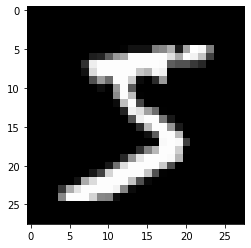

In [1]:
import numpy as np
import matplotlib.pyplot as plt

####### Step 1

# A function to plot images
def show_image(img):
    image = img.reshape((28, 28))
    plt.imshow(image, 'gray')


# Reading The Train Set
train_images_file = open('train-images.idx3-ubyte', 'rb')
train_images_file.seek(4)
num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
train_images_file.seek(16)

train_labels_file = open('train-labels.idx1-ubyte', 'rb')
train_labels_file.seek(8)

train_set = []
for n in range(num_of_train_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(train_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    train_set.append((image, label))


# Reading The Test Set
test_images_file = open('t10k-images.idx3-ubyte', 'rb')
test_images_file.seek(4)

test_labels_file = open('t10k-labels.idx1-ubyte', 'rb')
test_labels_file.seek(8)

num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
test_images_file.seek(16)

test_set = []
for n in range(num_of_test_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i] = int.from_bytes(test_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(test_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    test_set.append((image, label))


# Plotting an image
show_image(train_set[0][0])
plt.show()

In [2]:
####### Step 2

# separate first 100 pics from train set

train_set_f100 = train_set[:60000]

In [3]:
#print(test_set[0][0])


In [106]:

def sigmoid_activation(x):
    s=1/(1+np.exp(-x))
    ds=s*(1-s)  
    return s,ds

def predict(image, w, b, activation_func): 

    w_layer_2 = w[0]
    b_2 = b[0]
    
    w_layer_3 = w[1]
    b_3 = b[1]
    
    w_layer_4 = w[2]
    b_4 = b[2]

    a_s = []

    # layer 2
    a_2 = np.zeros((16, 1))
    a_2, _ = activation_func(w_layer_2 @ image[0] + b_2)
    a_s.append(np.transpose(a_2)[0].reshape(16,1))
    
    # layer 3
    a_3 = np.zeros((16, 1))
    a_3, _ = activation_func(w_layer_3 @ a_2 + b_3)
    a_s.append(np.transpose(a_3)[0].reshape(16,1))

    # layer 4
    a_4 = np.zeros((10, 1))
    a_4, _ = activation_func(np.transpose(w_layer_4 @ a_3) + b_4)
    a_4 = a_4[0].reshape(10,1)
    a_s.append(a_4)

    return a_4, a_s

def cal_accuracy(image_set, w, b, activation_func):

    correct = 0
    for i in range(len(image_set)):
        pre, _ = predict(image_set[i], w, b, activation_func)

        # examine
        if np.argmax(pre) == np.argmax(image_set[i][1]):
            correct += 1

    accuracy = correct/len(test_set)
    return accuracy

b = [np.zeros(16), np.zeros(16), np.zeros(10)] 
w = [np.random.randn(16, 784), np.random.randn(16, 16), np.random.randn(10, 16)]

acc = cal_accuracy(test_set, w, b, sigmoid_activation)
acc

0.089

In [107]:
####### Step 3
import copy

def next_batch(dataset, batchSize):
    for i in range(0, len(dataset), int(batchSize)):
        yield dataset[i:i + int(batchSize)]

def train(activation_func):
    cost_av = np.zeros(5)

    learning_rate = 1
    number_of_epochs = 5
    batch_size = 50 
    loss = None

    b = [np.zeros(16), np.zeros(16), np.zeros(10)] 
    w = [np.random.randn(16, 784), np.random.randn(16, 16), np.random.randn(10, 16)]


    for i in range(number_of_epochs):
        cost = 0
        cost_1 = 0

        for batch in list(next_batch(train_set_f100, batch_size)):

            grad_b = [np.zeros(16), np.zeros(16), np.zeros(10)] 
            grad_w = [np.zeros((16,784)), np.zeros((16,16)), np.zeros((10,16))]
            for image in batch:
                ans, a_s = predict(image, w, b, activation_func)
                ans = ans.reshape(10,1)
                a_2 = a_s[0]
                a_3 = a_s[1]
                a_4 = a_s[2]

                # ws of layer 4
                dcost_dw_4 = np.random.rand(10,16)
                dcost_db_4 = np.zeros(10)
                dcost_a_3 = np.zeros(16).reshape(16,1)
                
                z = (w[2] @ a_3)
                derivative, d_derivative = activation_func(z)

                dcost_dw_4 = (2*(ans - image[1]).reshape(10,1))*np.transpose(np.transpose(d_derivative)* a_3)
                dcost_db_4 = (2*(ans - image[1])).reshape(10,1)*d_derivative
                dcost_db_4 = dcost_db_4.reshape(10,)
                cost += ((ans - image[1])**2).sum()


                #as for layer 3
                dcost_a_3 = (np.transpose(2*(ans - image[1]).reshape(10,1)*(d_derivative)) @ w[2])[0].reshape(16,1)


                # ws of layer 3
                dcost_dw_3 = np.random.rand(16,16)
                dcost_db_3 = np.zeros(16)
                dcost_a_2 = np.zeros(16).reshape(16,1)

                z = (w[1] @ a_2)
                derivative, d_derivative = activation_func(z)
            
                dcost_dw_3 = dcost_a_3*np.transpose(np.transpose(d_derivative)* a_2)
                dcost_db_3 = dcost_a_3.reshape(16,1)*d_derivative
                dcost_db_3 = dcost_db_3.reshape(16,)

                #as for layer 2 
                dcost_a_2 = ((np.transpose(dcost_a_3*(d_derivative))[0]) @ w[1]).reshape(16,1)


                # ws of layer 2
                dcost_dw_2 = np.random.rand(16,784)
                dcost_db_2 = np.zeros(16)

                z = (w[0] @ image[0])
                derivative, d_derivative = activation_func(z)
            
                dcost_dw_2 = dcost_a_2*np.transpose(np.transpose(d_derivative)* image[0])
                dcost_db_2 = dcost_a_2.reshape(16,1)*d_derivative
                dcost_db_2 = dcost_db_2.reshape(16,)

                
                # grad_w += dcost/dw
                grad_w[2] = grad_w[2] + dcost_dw_4
                grad_w[1] = grad_w[1] + dcost_dw_3
                grad_w[0] = grad_w[0] + dcost_dw_2
                # grad_b += dcost/db
                grad_b[2] = grad_b[2] + dcost_db_4
                grad_b[1] = grad_b[1] + dcost_db_3
                grad_b[0] = grad_b[0] + dcost_db_2

            # W = W - (learning_rate × (grad_W / batch_size))
            w[2] = w[2] - (learning_rate*(grad_w[2]/batch_size))
            w[1] = w[1] - (learning_rate*(grad_w[1]/batch_size))
            w[0] = w[0] - (learning_rate*(grad_w[0]/batch_size))
            # b = b - (learning_rate × (grad_b / batch_size))
            b[2] = b[2] - (learning_rate*(grad_b[2]/batch_size))
            b[1] = b[1] - (learning_rate*(grad_b[1]/batch_size))
            b[0] = b[0] - (learning_rate*(grad_b[0]/batch_size))
        
        cost_av[i] = cost/50
    return w, b, cost_av

w, b, cost_av = train(sigmoid_activation)
acc = cal_accuracy(test_set, w, b, sigmoid_activation)
print(acc)
print(cost_av)





0.9019
[629.12541474 289.30698634 231.54447586 204.50100114 188.42507974]


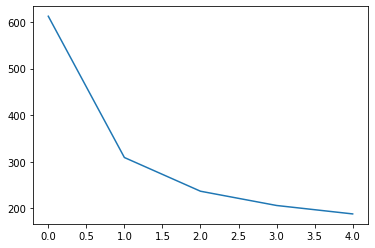

In [28]:
x = np.arange(5)
# corresponding y axis values
y = cost_av
  
# plotting the points 
plt.plot(x, y)

In [34]:
# Score question 1
test_set_2 = []

o = [i*28 for i in range(4)]
to_delete_ind = []
for j in range(0, 28*28, 28):
    temp = [i+j for i in range(24,28)]
    to_delete_ind += temp
new_black = np.zeros((28,4))

for i in range(len(test_set)):
    deleted_image = np.delete(test_set[i][0], to_delete_ind)
    deleted_image = deleted_image.reshape((28, 24))
    shifted_image = np.concatenate((new_black, deleted_image), axis=1)
    shifted_image = shifted_image.reshape(784, 1)
    test_set_2.append((shifted_image, test_set[i][1]))



In [55]:
acc = cal_accuracy(test_set_2, w, b)
print(acc)
print(cost_av)

0.2782
[612.27275081 309.26842731 236.97329772 206.38653302 188.29274215]


In [109]:
# Score question 2

def tanh_activation(x):
    t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    dt=1-t**2
    return t,dt



In [112]:
w, b, cost_av = train(tanh_activation)
acc = cal_accuracy(test_set, w, b, tanh_activation)
print(acc)
print(cost_av)

0.7504
[3952.24455383 2440.36029258 2322.21864193 2007.35049751 2055.55273002]
